In [8]:
import tensorflow as tf
#import keras
from tensorflow import lite

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50,inception_v3,nasnet
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from IPython.display import clear_output
from tensorflow import keras
import time
import datetime

import shutil

from tensorflow.compat.v1 import ConfigProto,InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


/home/hamza/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [9]:
print('number of train samples')
print(len(os.listdir('../input/datatree/train/nv')))
print(len(os.listdir('../input/datatree/train/mel')))
print(len(os.listdir('../input/datatree/train/bkl')))
print(len(os.listdir('../input/datatree/train/bcc')))
print(len(os.listdir('../input/datatree/train/akiec')))
print(len(os.listdir('../input/datatree/train/vasc')))
print(len(os.listdir('../input/datatree/train/df')))
print(len(os.listdir('../input/datatree/train/nod')))

number of train samples
4023
3895
3855
3610
3990
3490
2810
196


In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)

x_train = train_datagen.flow_from_directory(
    directory=r'../input/datatree/train/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=True,
    seed=42
)
train_generator = x_train
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weights = dict(enumerate(class_weights))
print("train_generator class_weights =",  class_weights)

validation_datagen = ImageDataGenerator(rescale=1./255)

x_validation = validation_datagen.flow_from_directory(
    directory=r'../input/datatree/validation/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=True,
    seed=42
)
validation_generator = x_validation
class_weights_val = class_weight.compute_class_weight('balanced', np.unique(validation_generator.classes), validation_generator.classes)
class_weights_val = dict(enumerate(class_weights_val))
class_weights_val
print("val_generator class_weights =",  class_weights_val)

test_datagen = ImageDataGenerator(rescale=1./255)

x_test = test_datagen.flow_from_directory(
    directory=r'../input/datatree/test/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_generator = x_test

num_train_samples = train_generator.n
num_val_samples = validation_generator.n
train_batch_size = 256
val_batch_size = 256


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
print(train_steps)
print(val_steps)

Found 25869 images belonging to 8 classes.
train_generator class_weights = {0: 0.8104323308270677, 1: 0.8957409972299168, 2: 0.8388132295719845, 3: 1.150756227758007, 4: 0.830198973042362, 5: 16.498086734693878, 6: 0.8037844891871737, 7: 0.9265401146131805}
Found 2068 images belonging to 8 classes.
val_generator class_weights = {0: 3.976923076923077, 1: 2.534313725490196, 2: 1.1803652968036529, 3: 11.23913043478261, 4: 1.1644144144144144, 5: 3.801470588235294, 6: 0.19276659209545116, 7: 9.232142857142858}
Found 2068 images belonging to 8 classes.
102.0
9.0


(224, 224, 3)


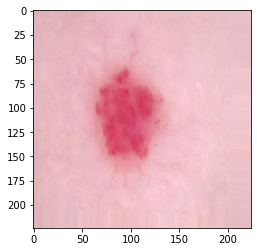

In [11]:
p = x_train.next()
print((p[0][0]).shape)
(plt.imshow(p[0][0][:,:,:]) )


In [12]:
lr =0.0001
def create_inception_model2(n_classes=8,learning_rate=lr):
    raw_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=n_classes)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    #for layer in raw_model.layers:
    #    layer.trainable = False
    full_model = Sequential()
    full_model.add(raw_model)
    full_model.add(GlobalAveragePooling2D())
    full_model.add(Dropout(0.2))
    full_model.add(Dense(512,activation='relu'))
    full_model.add(Dropout(0.1))
    full_model.add(Dense(8, activation = 'softmax'))
    full_model.compile(Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    full_model.summary()
    return full_model

In [13]:
model = create_inception_model2(n_classes=8,learning_rate=lr)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 22,855,976
Trainable params: 22,821,544
Non-trainable params: 34,432
_____________________________________

In [14]:
filepath = "../outputN/weights_part2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max',save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, 
                            validation_data=validation_generator,
                            validation_steps=val_steps,
                            epochs=50, verbose=1,
                            class_weight = class_weights,
                            shuffle=True,  
                            callbacks=callbacks_list)

Epoch 1/50
101/102 [============================>.] - ETA: 0s - loss: 1.1991 - accuracy: 0.5458
Epoch 00001: val_accuracy improved from -inf to 0.66319, saving model to ../outputN/weights_part2.h5
102/102 [==============================] - 38s 375ms/step - loss: 1.1942 - accuracy: 0.5472 - val_loss: 0.9057 - val_accuracy: 0.6632
Epoch 2/50
101/102 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.7321
Epoch 00002: val_accuracy improved from 0.66319 to 0.71875, saving model to ../outputN/weights_part2.h5
102/102 [==============================] - 36s 354ms/step - loss: 0.6445 - accuracy: 0.7322 - val_loss: 0.8438 - val_accuracy: 0.7188
Epoch 3/50
101/102 [============================>.] - ETA: 0s - loss: 0.4853 - accuracy: 0.7958
Epoch 00003: val_accuracy improved from 0.71875 to 0.75694, saving model to ../outputN/weights_part2.h5
102/102 [==============================] - 36s 355ms/step - loss: 0.4835 - accuracy: 0.7960 - val_loss: 0.7162 - val_accuracy: 0.7569
E

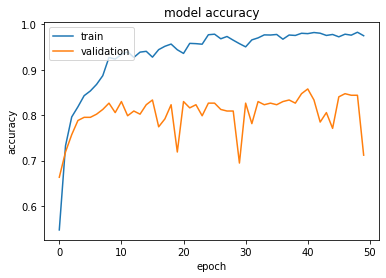

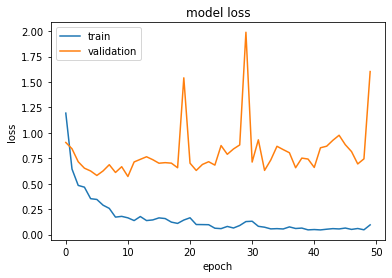

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
keras_model1 = "../outputN/SkinCancerI.pb"
keras.models.save_model(model,keras_model1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../outputN/SkinCancerI.pb/assets


In [19]:
keras.backend.clear_session()
converter = tf.lite.TFLiteConverter.from_saved_model(keras_model1)
tflite_model1 = converter.convert()
open("../outputN/model.tflite", "wb").write(tflite_model1)

91340100